In [1]:
from sklearn.datasets import load_breast_cancer
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
from collections import Counter
from functools import reduce
import math
import graphviz 

In [2]:
data = load_breast_cancer()

In [3]:
data.data.shape

(569, 30)

In [4]:
X_data = data.data
y_data = data.target

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.33, random_state=42)

In [6]:
dtc = DecisionTreeClassifier(criterion='entropy',max_depth=3)
dtc = dtc.fit(X_train, y_train)

In [7]:
dtc.score(X_test, y_test)

0.9414893617021277

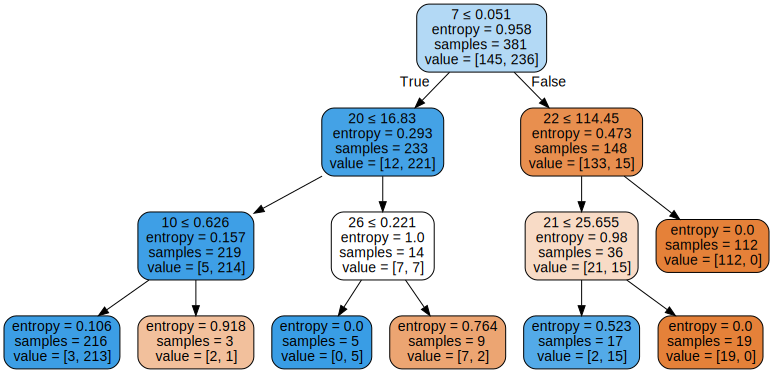

In [8]:
dot_data = tree.export_graphviz(dtc, out_file=None, 
                      feature_names=list(range(30)),    
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

In [9]:
class Node:
    def __init__(self, leaf=False, left=None, right=None, 
                 feature=None, split_point=None, majority=None):
        self.leaf = leaf
        self.left = left
        self.right = right
        self.feature = feature
        self.split_point = split_point
        self.majority = majority

In [10]:
class MyDecisionTreeClassifier:
    def __init__(self, max_split = 30):
        self.X_train = None
        self.y_train = None
        self.max_split = max_split
        self.tree = None
        self.c = 0
    
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        
        self.tree = self.generate_dt(self.X_train, self.y_train)
        return self
    
    def cal_entropy(self, label):
        partition = [v/len(label) for k, v in Counter(label).items()]
        return -sum([i*np.log2(i) for i in partition])
    
    def generate_dt(self, x,y):
        split_bool, info, data = self.node_split(x, y)
        self.c += 1 if split_bool else 0
        if split_bool and self.c < self.max_split:
            y_left, y_right, x_left, x_right = data
            return Node(leaf=False, left = self.generate_dt(x_left, y_left), right = self.generate_dt(x_right, y_right), feature=info[0], split_point=info[1])
        else:
            return Node(leaf=True, majority=Counter(y).most_common(1)[0][0])
        
    def node_split(self, x, y):
        n_label = np.unique(y)
        if len(n_label) == 1:
            return False, None, []
        n_features = x.shape[1]
        n_y = len(y)
        best_feature = None
        best_point2 = None
        best_entropy = math.inf
        for i in range(n_features):
            feature = x[:,i]
            sort_feature = np.sort(np.unique(feature))
            point = np.add(sort_feature[1:],sort_feature[:-1])/2
            best_point = None
            condition_entropy = math.inf
            for p in point:
                y_left= y[feature <= p]
                y_right = y[feature > p]
                e = self.cal_entropy(y_left) * len(y_left)/n_y + self.cal_entropy(y_right) * len(y_right)/n_y
                if e < condition_entropy:
                    condition_entropy = e
                    best_point = p
            if condition_entropy < best_entropy:
                best_entropy = condition_entropy
                best_feature = i
                best_point2 = best_point
        y_left= y[x[:,best_feature] <= best_point2]
        y_right= y[x[:,best_feature] >= best_point2]
        x_left = x[x[:,best_feature] <= best_point2,:]
        x_right = x[x[:,best_feature] >= best_point2,:]
        return True, (best_feature, best_point2, best_entropy), [y_left, y_right, x_left, x_right]
    
    def predict_one(self, x):
        pointer = self.tree
        while not pointer.leaf:
            feature = pointer.feature
            split_point = pointer.split_point
            if x[feature] <= split_point:
                pointer = pointer.left
            else:
                pointer = pointer.right
        return pointer.majority
    
    def predict(self, X):
        return np.array([self.predict_one(x) for x in X])

In [11]:
mydtc = MyDecisionTreeClassifier().fit(X_train, y_train)

In [12]:
accuracy_score(y_test, mydtc.predict(X_test))

0.9521276595744681